In [1]:
import pytesseract
#tesseract_folder = r'C:\Program Files\Tesseract-OCR'
#pytesseract.pytesseract.tesseract_cmd = rf'{tesseract_folder}\tesseract.exe'

In [2]:
from transformers import ViTFeatureExtractor, ViTModel
from PIL import Image
import torch
def extract_visual_embeddings(image_path):
    image_input=image_path
    if isinstance(image_input, str):
        image = Image.open(image_input).convert("RGB")
    elif isinstance(image_input, Image.Image):
        image = image_input
    else:
        raise TypeError("Invalid input type for image. Expected a file path or PIL.Image.Image object.")

    feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
    model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
    #image = Image.open(image_path).convert("RGB")
    inputs = feature_extractor(images=image, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
        image_embeddings = outputs.last_hidden_state
    return image_embeddings.squeeze(0).detach().numpy().flatten()

In [3]:
from PIL import Image
import pytesseract
from transformers import LayoutLMTokenizer, LayoutLMModel
import torch
import torch.nn as nn
import pandas as pd
def process_image(image_path):
    image_input=image_path
    if isinstance(image_input, str):
        image = Image.open(image_input)
    elif isinstance(image_input, Image.Image):
        image = image_input
    else:
        raise TypeError("Invalid input type for image. Expected a file path or PIL.Image.Image object.")

    #image = Image.open(image_path)

    texte_data = pytesseract.image_to_data(image, output_type=pytesseract.Output.DICT)

   
    words = []
    normalized_word_boxes = []
    max_word_length = 512 

    for i in range(len(texte_data['text'])):
        word = texte_data['text'][i].strip()
        if word and len(word) <= max_word_length:
            box = (
                int(texte_data['left'][i]),
                int(texte_data['top'][i]),
                int(texte_data['left'][i] + texte_data['width'][i]),
                int(texte_data['top'][i] + texte_data['height'][i])
            )
            words.append(word)
            normalized_word_boxes.append(box)
    if not any(len(word) <= max_word_length for word in words):
        return None 
  
    tokenizer = LayoutLMTokenizer.from_pretrained('microsoft/layoutlm-base-uncased')
    model = LayoutLMModel.from_pretrained('microsoft/layoutlm-base-uncased')

    
    token_boxes = []
    for word, box in zip(words, normalized_word_boxes):
        word_tokens = tokenizer.tokenize(word)
        token_boxes.extend([box] * len(word_tokens))
    
    # Add bounding boxes of cls + sep tokens
    token_boxes = [[0, 0, 0, 0]] + token_boxes + [[1000, 1000, 1000, 1000]]

    # Encode input for the LayoutLM model
    encoding = tokenizer(' '.join(words), return_tensors="pt")

    input_ids = encoding["input_ids"]
    max_seq_length = 512 
    
    if input_ids.size(1) > max_seq_length:
        
        input_ids = input_ids[:, :max_seq_length]
    attention_mask = encoding["attention_mask"]
    token_type_ids = encoding["token_type_ids"]
    if attention_mask.size(1) > max_seq_length:
        attention_mask = attention_mask[:, :max_seq_length]

    if token_type_ids.size(1) > max_seq_length:
        token_type_ids = token_type_ids[:, :max_seq_length]
    bbox = torch.tensor([token_boxes])
    if bbox.size(1) > max_seq_length:
    
        bbox = bbox[:, :max_seq_length, :]
    bbox[:, :, :2] = torch.clamp(bbox[:, :, :2], min=0, max=1000)
    bbox[:, :, 2:] = torch.clamp(bbox[:, :, 2:], min=0, max=1000)
    
    outputs = model(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids)
    last_hidden_states = outputs.last_hidden_state
    last_hidden_states = last_hidden_states.squeeze(0).detach().numpy().flatten()
    
    return last_hidden_states

In [4]:
def cross_attention(text_embeddings, visual_embeddings):
    
    scores = torch.matmul(text_embeddings, visual_embeddings.transpose(-1, 0))

    weights = torch.nn.functional.softmax(scores, dim=-1)

    enriched_embeddings = torch.matmul(weights, visual_embeddings)
    
    return enriched_embeddings

**clustering codes**

In [5]:
import hdbscan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, silhouette_score, calinski_harabasz_score
from sklearn.metrics.cluster import contingency_matrix


In [6]:
def calculate_purity(y_true, y_pred):
    cont_matrix = contingency_matrix(y_true, y_pred)
    return np.sum(np.amax(cont_matrix, axis=0)) / np.sum(cont_matrix)


In [7]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, normalized_mutual_info_score, adjusted_rand_score
#import hdbscan

def perform_clustering(X, optimal_num_clusters):
    # KMeans clustering
    kmeans = KMeans(n_clusters=optimal_num_clusters, random_state=42).fit(X)
    kmeans_labels = kmeans.labels_

    # Agglomerative clustering
    agglo = AgglomerativeClustering(n_clusters=optimal_num_clusters).fit(X)
    agglo_labels = agglo.labels_

    # HDBSCAN clustering
    hdbscan_cluster = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=1).fit(X)
    hdbscan_labels = hdbscan_cluster.labels_
    #return X, kmeans_labels, agglo_labels
    return X, kmeans_labels, agglo_labels, hdbscan_labels





In [8]:
from sklearn.metrics import silhouette_score, normalized_mutual_info_score, adjusted_rand_score, calinski_harabasz_score
def evaluate_metrics(X, labels_true, kmeans_labels, agglo_labels,hdbscan_labels):
    metrics = {
        'KMeans': {
            'Silhouette': silhouette_score(X, kmeans_labels),
            'NMI': normalized_mutual_info_score(labels_true, kmeans_labels),
            'ARI': adjusted_rand_score(labels_true, kmeans_labels),
            'Purity': calculate_purity(labels_true, kmeans_labels),
            'Calinski': calinski_harabasz_score(X, kmeans_labels)
        },
        'Agglomerative': {
            'Silhouette': silhouette_score(X, agglo_labels),
            'NMI': normalized_mutual_info_score(labels_true, agglo_labels),
            'ARI': adjusted_rand_score(labels_true, agglo_labels),
            'Purity': calculate_purity(labels_true, agglo_labels),
            'Calinski': calinski_harabasz_score(X, agglo_labels)
        },
        'HDBSCAN': {
            'Silhouette': silhouette_score(X, hdbscan_labels) if len(set(hdbscan_labels)) > 1 else 'NA',
            'NMI': normalized_mutual_info_score(labels_true, hdbscan_labels),
            'ARI': adjusted_rand_score(labels_true, hdbscan_labels),
            'Purity': calculate_purity(labels_true, hdbscan_labels),
            'Calinski': calinski_harabasz_score(X, hdbscan_labels) if len(set(hdbscan_labels)) > 1 else 'NA'
        }
    }
    return metrics


In [9]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def find_optimal_clusters(data, min_clusters=2, max_clusters=16):
    best_score = -1
    best_cluster = 1

    for n_clusters in range(min_clusters, max_clusters + 1):
        
        clusterer = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = clusterer.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
    
        print(f"For n_clusters = {n_clusters}, the Silhouette Score is : {silhouette_avg}")
        
        
        if silhouette_avg > best_score:
            best_score = silhouette_avg
            best_cluster = n_clusters
            
    return best_cluster


In [10]:
import matplotlib.pyplot as plt
def plot_clusters(X, labels, algorithm_name):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    plt.figure(figsize=(10, 6))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', marker='o', alpha=0.7)
    plt.title(f'PCA Plot of {algorithm_name} Clusters')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.colorbar()
    plt.show()


**see clusters**

In [11]:
import os
import shutil

def create_cluster_folders(base_dir, labels, file_paths, folder_name):
    """
    Create folders for each cluster and copy files into the respective folder.
    
    Parameters:
        base_dir (str): Base directory where the cluster folders will be created.
        labels (list): List of labels corresponding to each file, determining the cluster.
        file_paths (list): List of file paths for the files to be copied.
        folder_name (str): Name of the main folder to contain all the clusters.
    """
    clusters_dir = os.path.join(base_dir, folder_name)
    if not os.path.exists(clusters_dir):
        os.makedirs(clusters_dir)

    for label, file_path in zip(labels, file_paths):
        cluster_folder = os.path.join(clusters_dir, f"cluster_{label}")
        if not os.path.exists(cluster_folder):
            os.makedirs(cluster_folder)

        new_file_path = os.path.join(cluster_folder, os.path.basename(file_path))
        shutil.copy(file_path, new_file_path)
        print(f"File {file_path} copied to {new_file_path}")



**rvl-cdip**

In [12]:
import pytesseract
from transformers import LayoutLMTokenizer, LayoutLMModel
import torch
import pandas as pd
import os
from PIL import Image
import random

image_dir = 'rvl-cdip-small-200/train'
labels = []
results = []
resutls2 = []
image_paths = [] 

for root, dirs, files in os.walk(image_dir):
    for file in files:
        if file.endswith(('.tif', '.tiff')):
            image_path = os.path.join(root, file)
            image_paths.append(image_path)


sample_size = int(1 * len(image_paths))  
sampled_paths = random.sample(image_paths, sample_size)  
processed_image_paths = []
for image_path in sampled_paths:
    label = os.path.basename(os.path.dirname(image_path))
    labels.append(label)

    with Image.open(image_path) as img:
        png_path = image_path.rsplit('.', 1)[0] + '.png'
        img.save(png_path, "PNG")
    processed_image_paths.append(png_path)
    result = process_image(png_path)
    if result is not None:
        results.append(torch.tensor(result))
    else:
        print(f"Warning: processing returned None for image {png_path}")
    
    result2 = extract_visual_embeddings(png_path)
    if result2 is not None:
        resutls2.append(torch.tensor(result2))
    else:
        print(f"Warning: processing returned None for image {png_path}")


/home/guenael/anaconda3/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (578 > 512). Running this sequence through the model will result in indexing errors
/home/guenael/anaconda3/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (815 > 512). Running this sequence through the model will result in indexing errors
/home/guenael/anaconda3/lib/python3.11/site-packages/transformers/models/vit/feature_extractio

/home/guenael/anaconda3/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (1377 > 512). Running this sequence through the model will result in indexing errors
/home/guenael/anaconda3/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
/home/guenael/anaconda3/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Toke

/home/guenael/anaconda3/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
/home/guenael/anaconda3/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
/home/guenael/anaconda3/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
/home/guenael/anaconda3/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed i

/home/guenael/anaconda3/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
/home/guenael/anaconda3/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
/home/guenael/anaconda3/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
/home/guenael/anaconda3/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed i

/home/guenael/anaconda3/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
/home/guenael/anaconda3/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
/home/guenael/anaconda3/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (1553 > 512). Running this sequence through the model will result in indexing errors
/hom

/home/guenael/anaconda3/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
/home/guenael/anaconda3/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
/home/guenael/anaconda3/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
/home/guenael/anaconda3/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed i

/home/guenael/anaconda3/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
/home/guenael/anaconda3/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (579 > 512). Running this sequence through the model will result in indexing errors
/home/guenael/anaconda3/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
/home

/home/guenael/anaconda3/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (1071 > 512). Running this sequence through the model will result in indexing errors
/home/guenael/anaconda3/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (849 > 512). Running this sequence through the model will result in indexing errors
/home/guenael/anaconda3/lib/python3.11/site-packages/transformers/models/vit/feature_extracti

/home/guenael/anaconda3/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (629 > 512). Running this sequence through the model will result in indexing errors
/home/guenael/anaconda3/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (1155 > 512). Running this sequence through the model will result in indexing errors
/home/guenael/anaconda3/lib/python3.11/site-packages/transformers/models/vit/feature_extracti

/home/guenael/anaconda3/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (1518 > 512). Running this sequence through the model will result in indexing errors
/home/guenael/anaconda3/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (724 > 512). Running this sequence through the model will result in indexing errors
/home/guenael/anaconda3/lib/python3.11/site-packages/transformers/models/vit/feature_extracti

In [13]:
import torch.nn.functional as F

jagged_tensor = torch.nn.utils.rnn.pad_sequence(results, batch_first=True)
jagged_tensor2 = torch.nn.utils.rnn.pad_sequence(resutls2, batch_first=True)

min_feature_dim = max(jagged_tensor.size(-1), jagged_tensor2.size(-1))#

def adjust_embeddings(embeddings, target_dim):
    current_dim = embeddings.size(-1)

    if current_dim > target_dim:
        adjusted_embeddings = embeddings[:, :, :target_dim]


    elif current_dim < target_dim:
        padding_size = target_dim - current_dim
        adjusted_embeddings = F.pad(embeddings, (0, padding_size), "constant", 0)
    else:
       
        adjusted_embeddings = embeddings
    return adjusted_embeddings


jagged_tensor_adjusted = adjust_embeddings(jagged_tensor, min_feature_dim)
jagged_tensor2_adjusted = adjust_embeddings(jagged_tensor2, min_feature_dim)

embed = cross_attention(jagged_tensor_adjusted, jagged_tensor2_adjusted)

In [14]:
embed_df = pd.DataFrame(embed.numpy())
print(embed_df)
labels_df = pd.DataFrame(labels, columns=['label'])
labels_df = labels_df.reindex(embed_df.index)
embed_df['label'] = labels_df['label']

       0         1         2         3         4         5         6       \
0   -0.226281  0.026408 -0.082933 -0.155986  0.004296  0.042812  0.041467   
1    0.201799  0.008626 -0.055978  0.204539 -0.218272 -0.032939  0.016812   
2    0.201799  0.008626 -0.055978  0.204539 -0.218272 -0.032939  0.016812   
3    0.201799  0.008626 -0.055978  0.204539 -0.218272 -0.032939  0.016812   
4    0.201799  0.008626 -0.055978  0.204539 -0.218272 -0.032939  0.016812   
..        ...       ...       ...       ...       ...       ...       ...   
755  0.185039 -0.019636  0.022793  0.282780 -0.126505  0.061749  0.143550   
756  0.201799  0.008626 -0.055978  0.204539 -0.218272 -0.032939  0.016812   
757  0.199929  0.007740 -0.055734  0.202036 -0.217821 -0.033324  0.017482   
758  0.201799  0.008626 -0.055978  0.204539 -0.218272 -0.032939  0.016812   
759  0.201799  0.008626 -0.055978  0.204539 -0.218272 -0.032939  0.016812   

       7         8         9       ...  393206  393207  393208  393209  \
0

In [15]:
embed_df

,0,1,2,3,4,5,6,7,8,9,...,393207,393208,393209,393210,393211,393212,393213,393214,393215,label
0,-0.226281,0.026408,-0.082933,-0.155986,0.004296,0.042812,0.041467,0.067415,-0.192202,-0.222933,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,scientific_report
1,0.201799,0.008626,-0.055978,0.204539,-0.218272,-0.032939,0.016812,0.116191,-0.129886,-0.180650,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,questionnaire
2,0.201799,0.008626,-0.055978,0.204539,-0.218272,-0.032939,0.016812,0.116191,-0.129886,-0.180650,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,resume
3,0.201799,0.008626,-0.055978,0.204539,-0.218272,-0.032939,0.016812,0.116191,-0.129886,-0.180650,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,scientific_report
4,0.201799,0.008626,-0.055978,0.204539,-0.218272,-0.032939,0.016812,0.116191,-0.129886,-0.180650,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,questionnaire
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,0.185039,-0.019636,0.022793,0.282780,-0.126505,0.061749,0.143550,0.024730,0.032948,-0.265967,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,scientific_report
756,0.201799,0.008626,-0.055978,0.204539,-0.218272,-0.032939,0.016812,0.116191,-0.129886,-0.180650,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,scientific_report
757,0.199929,0.007740,-0.055734,0.202036,-0.217821,-0.033324,0.017482,0.116248,-0.130210,-0.180328,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,scientific_publication
758,0.201799,0.008626,-0.055978,0.204539,-0.218272,-0.032939,0.016812,0.116191,-0.129886,-0.180650,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,scientific_report


In [16]:
X = embed_df.drop('label', axis=1)
labels_true_df = labels_df['label']
optimal_num_clusters = find_optimal_clusters(X,2,16)


/home/guenael/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 2, the Silhouette Score is : 0.7329738140106201


/home/guenael/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 3, the Silhouette Score is : 0.7773464918136597


/home/guenael/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 4, the Silhouette Score is : 0.8167389035224915


/home/guenael/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 5, the Silhouette Score is : 0.8484760522842407


/home/guenael/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 6, the Silhouette Score is : 0.8635764718055725


/home/guenael/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 7, the Silhouette Score is : 0.8772096037864685


/home/guenael/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 8, the Silhouette Score is : 0.8850756287574768


/home/guenael/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 9, the Silhouette Score is : 0.9013823866844177


/home/guenael/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 10, the Silhouette Score is : 0.9113536477088928


/home/guenael/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 11, the Silhouette Score is : 0.9285979270935059


/home/guenael/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 12, the Silhouette Score is : 0.931288480758667


/home/guenael/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 13, the Silhouette Score is : 0.9365245699882507


/home/guenael/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 14, the Silhouette Score is : 0.9389208555221558


/home/guenael/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 15, the Silhouette Score is : 0.9429697394371033


/home/guenael/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 16, the Silhouette Score is : 0.943376898765564


In [17]:

X_pca, kmeans_labels, agglo_labels,hdb_labels = perform_clustering(X, optimal_num_clusters)
metrics = evaluate_metrics(X_pca, labels_df['label'], kmeans_labels, agglo_labels,hdb_labels)

for algo, algo_metrics in metrics.items():
    print(f"{algo} Metrics:")
    for metric, value in algo_metrics.items():
        print(f"  {metric}: {value}")

/home/guenael/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans Metrics:
  Silhouette: 0.943376898765564
  NMI: 0.0313484699907513
  ARI: 0.0013287144440310387
  Purity: 0.24736842105263157
  Calinski: 950.2854035577254
Agglomerative Metrics:
  Silhouette: 0.9423783421516418
  NMI: 0.031207403545613716
  ARI: 0.0014176163299873556
  Purity: 0.24736842105263157
  Calinski: 937.866812133089
HDBSCAN Metrics:
  Silhouette: 0.9262048602104187
  NMI: 0.020601716721153306
  ARI: 0.0017035308704066551
  Purity: 0.24342105263157895
  Calinski: 749.3566532096705


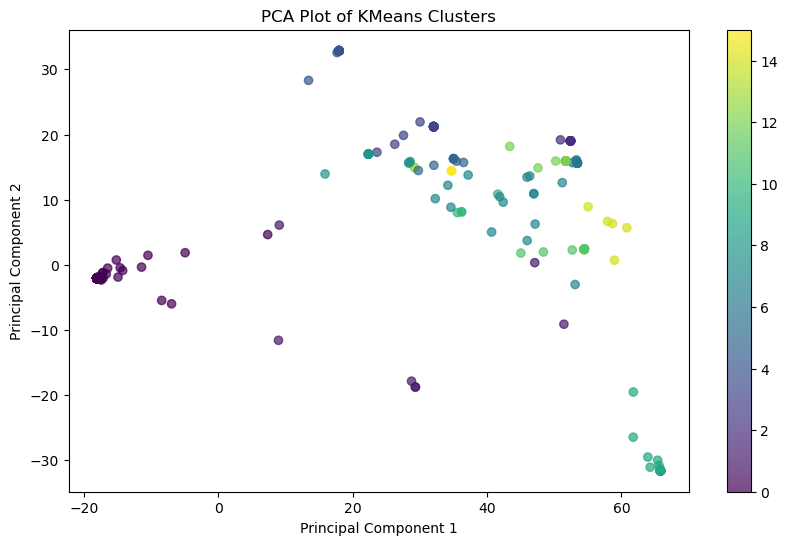

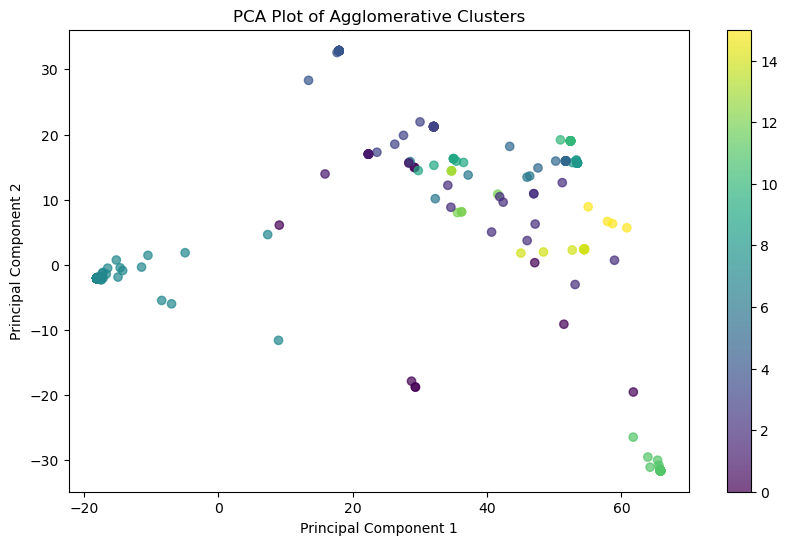

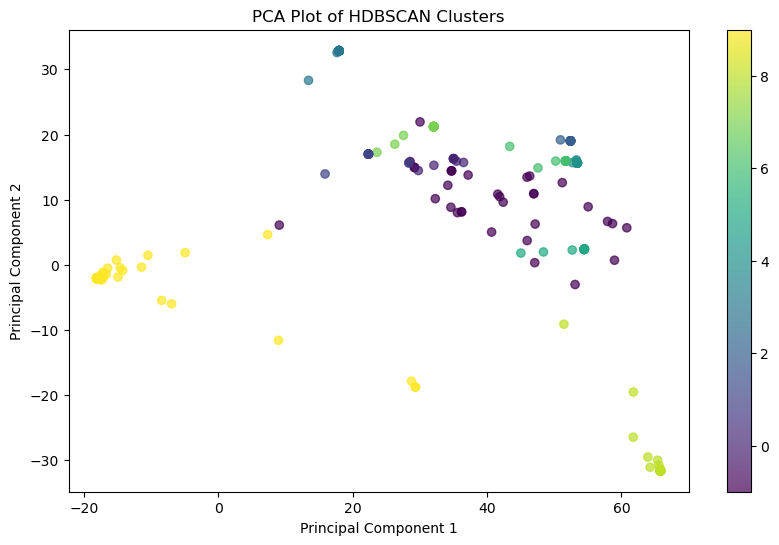

In [18]:
plot_clusters(X_pca, kmeans_labels, 'KMeans')
plot_clusters(X_pca, agglo_labels, 'Agglomerative')
plot_clusters(X_pca,hdb_labels, 'HDBSCAN')

In [19]:
# Usage example
base_dir = 'result_cluster_cross'
folder_name = 'clusters_cross_rvl'  # You can now specify the folder name dynamically
create_cluster_folders(base_dir, kmeans_labels, processed_image_paths, folder_name)


File rvl-cdip-small-200/train/scientific_report/00101551.png copied to result_cluster_cross/clusters_cross_rvl/cluster_9/00101551.png
File rvl-cdip-small-200/train/questionnaire/0060004814.png copied to result_cluster_cross/clusters_cross_rvl/cluster_0/0060004814.png
File rvl-cdip-small-200/train/resume/50616282-6283.png copied to result_cluster_cross/clusters_cross_rvl/cluster_0/50616282-6283.png
File rvl-cdip-small-200/train/scientific_report/2501622704_2501622719.png copied to result_cluster_cross/clusters_cross_rvl/cluster_0/2501622704_2501622719.png
File rvl-cdip-small-200/train/questionnaire/2040461844_2040461845.png copied to result_cluster_cross/clusters_cross_rvl/cluster_0/2040461844_2040461845.png
File rvl-cdip-small-200/train/specification/2031321114.png copied to result_cluster_cross/clusters_cross_rvl/cluster_4/2031321114.png
File rvl-cdip-small-200/train/specification/2069728381.png copied to result_cluster_cross/clusters_cross_rvl/cluster_6/2069728381.png
File rvl-cdip-s

**doclaynet**

In [20]:
import pytesseract
from transformers import LayoutLMTokenizer, LayoutLMModel
import torch
from PIL import Image
import random
from datasets import load_dataset


dataset = load_dataset("pierreguillou/DocLayNet-small")

labels = []
results = []
results2 = []

sample_size = int(1 * len(dataset['train']))  
sampled_data = random.sample(list(dataset['train']), sample_size)
processed_image_paths = []
for sample in sampled_data:
    image_path_or_data = sample['image']
    label = sample['doc_category']
    labels.append(label)
    if isinstance(image_path_or_data, str):
        image = Image.open(image_path_or_data)
    else:
        image = image_path_or_data
    processed_image_paths.append(png_path)
    result = process_image(png_path)
    if result is not None:
        results.append(torch.tensor(result))
    else:
        print(f"Warning: processing returned None for image {png_path}")
    
    result2 = extract_visual_embeddings(png_path)
    if result2 is not None:
        resutls2.append(torch.tensor(result2))
    else:
        print(f"Warning: processing returned None for image {png_path}")






/home/guenael/anaconda3/lib/python3.11/site-packages/datasets/load.py:1461: FutureWarning: The repository for pierreguillou/DocLayNet-small contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/pierreguillou/DocLayNet-small
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (522 > 512). Running this sequence through the model will result in indexing errors
/home/guenael/anaconda3/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Token indices sequ

In [21]:
results

[tensor([ 0.0015,  0.2247, -0.0072,  ...,  0.3118,  0.0515, -0.1975]),
 tensor([ 0.0015,  0.2247, -0.0072,  ...,  0.3118,  0.0515, -0.1975]),
 tensor([ 0.0015,  0.2247, -0.0072,  ...,  0.3118,  0.0515, -0.1975]),
 tensor([ 0.0015,  0.2247, -0.0072,  ...,  0.3118,  0.0515, -0.1975]),
 tensor([ 0.0015,  0.2247, -0.0072,  ...,  0.3118,  0.0515, -0.1975]),
 tensor([ 0.0015,  0.2247, -0.0072,  ...,  0.3118,  0.0515, -0.1975]),
 tensor([ 0.0015,  0.2247, -0.0072,  ...,  0.3118,  0.0515, -0.1975]),
 tensor([ 0.0015,  0.2247, -0.0072,  ...,  0.3118,  0.0515, -0.1975]),
 tensor([ 0.0015,  0.2247, -0.0072,  ...,  0.3118,  0.0515, -0.1975]),
 tensor([ 0.0015,  0.2247, -0.0072,  ...,  0.3118,  0.0515, -0.1975]),
 tensor([ 0.0015,  0.2247, -0.0072,  ...,  0.3118,  0.0515, -0.1975]),
 tensor([ 0.0015,  0.2247, -0.0072,  ...,  0.3118,  0.0515, -0.1975]),
 tensor([ 0.0015,  0.2247, -0.0072,  ...,  0.3118,  0.0515, -0.1975]),
 tensor([ 0.0015,  0.2247, -0.0072,  ...,  0.3118,  0.0515, -0.1975]),
 tenso

In [22]:
import torch.nn.functional as F

jagged_tensor = torch.nn.utils.rnn.pad_sequence(results, batch_first=True)
jagged_tensor2 = torch.nn.utils.rnn.pad_sequence(resutls2, batch_first=True)

min_feature_dim = max(jagged_tensor.size(-1), jagged_tensor2.size(-1))#

def adjust_embeddings(embeddings, target_dim):
    current_dim = embeddings.size(-1)

    if current_dim > target_dim:
        adjusted_embeddings = embeddings[:, :, :target_dim]


    elif current_dim < target_dim:
        padding_size = target_dim - current_dim
        adjusted_embeddings = F.pad(embeddings, (0, padding_size), "constant", 0)
    else:
       
        adjusted_embeddings = embeddings
    return adjusted_embeddings


jagged_tensor_adjusted = adjust_embeddings(jagged_tensor, min_feature_dim)
jagged_tensor2_adjusted = adjust_embeddings(jagged_tensor2, min_feature_dim)

embed = cross_attention(jagged_tensor_adjusted, jagged_tensor2_adjusted)

In [23]:
embed_df = pd.DataFrame(embed.numpy())
print(embed_df)
labels_df = pd.DataFrame(labels, columns=['label'])
labels_df = labels_df.reindex(embed_df.index)
embed_df['label'] = labels_df['label']

       0         1         2         3         4         5         6       \
0    0.201799  0.008626 -0.055978  0.204539 -0.218272 -0.032939  0.016812   
1    0.201799  0.008626 -0.055978  0.204539 -0.218272 -0.032939  0.016812   
2    0.201799  0.008626 -0.055978  0.204539 -0.218272 -0.032939  0.016812   
3    0.201799  0.008626 -0.055978  0.204539 -0.218272 -0.032939  0.016812   
4    0.201799  0.008626 -0.055978  0.204539 -0.218272 -0.032939  0.016812   
..        ...       ...       ...       ...       ...       ...       ...   
686  0.201799  0.008626 -0.055978  0.204539 -0.218272 -0.032939  0.016812   
687  0.201799  0.008626 -0.055978  0.204539 -0.218272 -0.032939  0.016812   
688  0.201799  0.008626 -0.055978  0.204539 -0.218272 -0.032939  0.016812   
689  0.201799  0.008626 -0.055978  0.204539 -0.218272 -0.032939  0.016812   
690  0.201799  0.008626 -0.055978  0.204539 -0.218272 -0.032939  0.016812   

       7         8        9       ...  393206  393207  393208  393209  3932

In [24]:
X = embed_df.drop('label', axis=1)
labels_true_df = labels_df['label']
optimal_num_clusters = find_optimal_clusters(X,2,6)


/home/guenael/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/guenael/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

In [ ]:

X_pca, kmeans_labels, agglo_labels,hdb_labels = perform_clustering(X, optimal_num_clusters)
metrics = evaluate_metrics(X_pca, labels_df['label'], kmeans_labels, agglo_labels,hdb_labels)

for algo, algo_metrics in metrics.items():
    print(f"{algo} Metrics:")
    for metric, value in algo_metrics.items():
        print(f"  {metric}: {value}")

In [ ]:
plot_clusters(X_pca, kmeans_labels, 'KMeans')
plot_clusters(X_pca, agglo_labels, 'Agglomerative')
plot_clusters(X_pca,hdb_labels, 'HDBSCAN')

In [ ]:
# Usage example
base_dir = 'result_cluster_cross'
folder_name = 'clusters_cross_doclaynet'  # You can now specify the folder name dynamically
create_cluster_folders(base_dir, kmeans_labels, processed_image_paths, folder_name)


**sroie2019**

In [ ]:
from PIL import Image
import torch
import os
import random
image_paths = []
results = []
resutls2 = []  

image_dir = 'organized for conference\sroie2019'


for root, dirs, files in os.walk(image_dir):
    for file in files:
        if file.endswith(('.jpg')):  
            image_path = os.path.join(root, file)
            image_paths.append(image_path)
            

sample_size = int(1* len(image_paths))  
sampled_paths = random.sample(image_paths, sample_size)  

# Process each sampled image and convert to PNG
processed_image_paths = []  # This will store the paths to the processed images
for image_path in sampled_paths:
    label = os.path.basename(os.path.dirname(image_path))
    labels.append(label)

    png_path = image_path.rsplit('.', 1)[0] + '.png'
    with Image.open(image_path) as img:
        img.save(png_path, "PNG")
    processed_image_paths.append(png_path)
    result = process_image(png_path)
    if result is not None:
        results.append(torch.tensor(result))
    else:
        print(f"Warning: processing returned None for image {png_path}")
    
    result2 = extract_visual_embeddings(png_path)
    if result2 is not None:
        resutls2.append(torch.tensor(result2))
    else:
        print(f"Warning: processing returned None for image {png_path}")


In [ ]:
import torch.nn.functional as F

jagged_tensor = torch.nn.utils.rnn.pad_sequence(results, batch_first=True)
jagged_tensor2 = torch.nn.utils.rnn.pad_sequence(resutls2, batch_first=True)

min_feature_dim = max(jagged_tensor.size(-1), jagged_tensor2.size(-1))#

def adjust_embeddings(embeddings, target_dim):
    current_dim = embeddings.size(-1)

    if current_dim > target_dim:
        adjusted_embeddings = embeddings[:, :, :target_dim]


    elif current_dim < target_dim:
        padding_size = target_dim - current_dim
        adjusted_embeddings = F.pad(embeddings, (0, padding_size), "constant", 0)
    else:
       
        adjusted_embeddings = embeddings
    return adjusted_embeddings


jagged_tensor_adjusted = adjust_embeddings(jagged_tensor, min_feature_dim)
jagged_tensor2_adjusted = adjust_embeddings(jagged_tensor2, min_feature_dim)

embed = cross_attention(jagged_tensor_adjusted, jagged_tensor2_adjusted)

In [ ]:
embed_df = pd.DataFrame(embed.numpy())
print(embed_df)
#labels_df = pd.DataFrame(labels, columns=['label'])
#labels_df = labels_df.reindex(embed_df.index)
#embed_df['label'] = labels_df['label']

In [ ]:
embed_df

In [ ]:
X = embed_df
#labels_true_df = labels_df['label']
optimal_num_clusters = find_optimal_clusters(X,2,6)


In [ ]:

X_pca, kmeans_labels, agglo_labels,hdb_labels = perform_clustering(X, optimal_num_clusters)
metrics = evaluate_metrics(X_pca, labels_df['label']==0, kmeans_labels, agglo_labels,hdb_labels)

for algo, algo_metrics in metrics.items():
    print(f"{algo} Metrics:")
    for metric, value in algo_metrics.items():
        print(f"  {metric}: {value}")

In [ ]:
plot_clusters(X_pca, kmeans_labels, 'KMeans')
plot_clusters(X_pca, agglo_labels, 'Agglomerative')
plot_clusters(X_pca,hdb_labels, 'HDBSCAN')

In [ ]:
# Usage example
base_dir = 'result_cluster_cross'
folder_name = 'clusters_cross_3'  # You can now specify the folder name dynamically
create_cluster_folders(base_dir, kmeans_labels, processed_image_paths, folder_name)
